In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

In [3]:
sc = SparkContext(master='local', appName='Ex2')
spark = SparkSession(sc)

### Explore Data

In [4]:
data = spark.read.csv('./dog_food.csv',inferSchema=True,header=True)

In [5]:
data.printSchema()

root
 |-- A: integer (nullable = true)
 |-- B: integer (nullable = true)
 |-- C: double (nullable = true)
 |-- D: integer (nullable = true)
 |-- Spoiled: double (nullable = true)



In [6]:
data.show(3)

+---+---+----+---+-------+
|  A|  B|   C|  D|Spoiled|
+---+---+----+---+-------+
|  4|  2|12.0|  3|    1.0|
|  5|  6|12.0|  7|    1.0|
|  6|  2|13.0|  6|    1.0|
+---+---+----+---+-------+
only showing top 3 rows



### Pre-processing

In [7]:
from pyspark.sql.functions import col, when, count, isnan, isnull

##### Check dữ liệu thiếu:

In [10]:
data.select([count(when(isnan(col),col)).alias(col) for col in data.columns]).toPandas()

,A,B,C,D,Spoiled
0,0,0,0,0,0


In [11]:
data.select([count(when(isnull(col),col)).alias(col) for col in data.columns]).toPandas()

,A,B,C,D,Spoiled
0,0,0,0,0,0


##### Check dữ liệu trùng lặp

In [12]:
duplicate_rows = data.count() - data.distinct().count()
print('Số hàng bị trùng lặp: ',duplicate_rows)

Số hàng bị trùng lặp:  19


In [13]:
data = data.drop_duplicates()

##### Scaling

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [16]:
chem_list = data.drop('Spoiled').columns

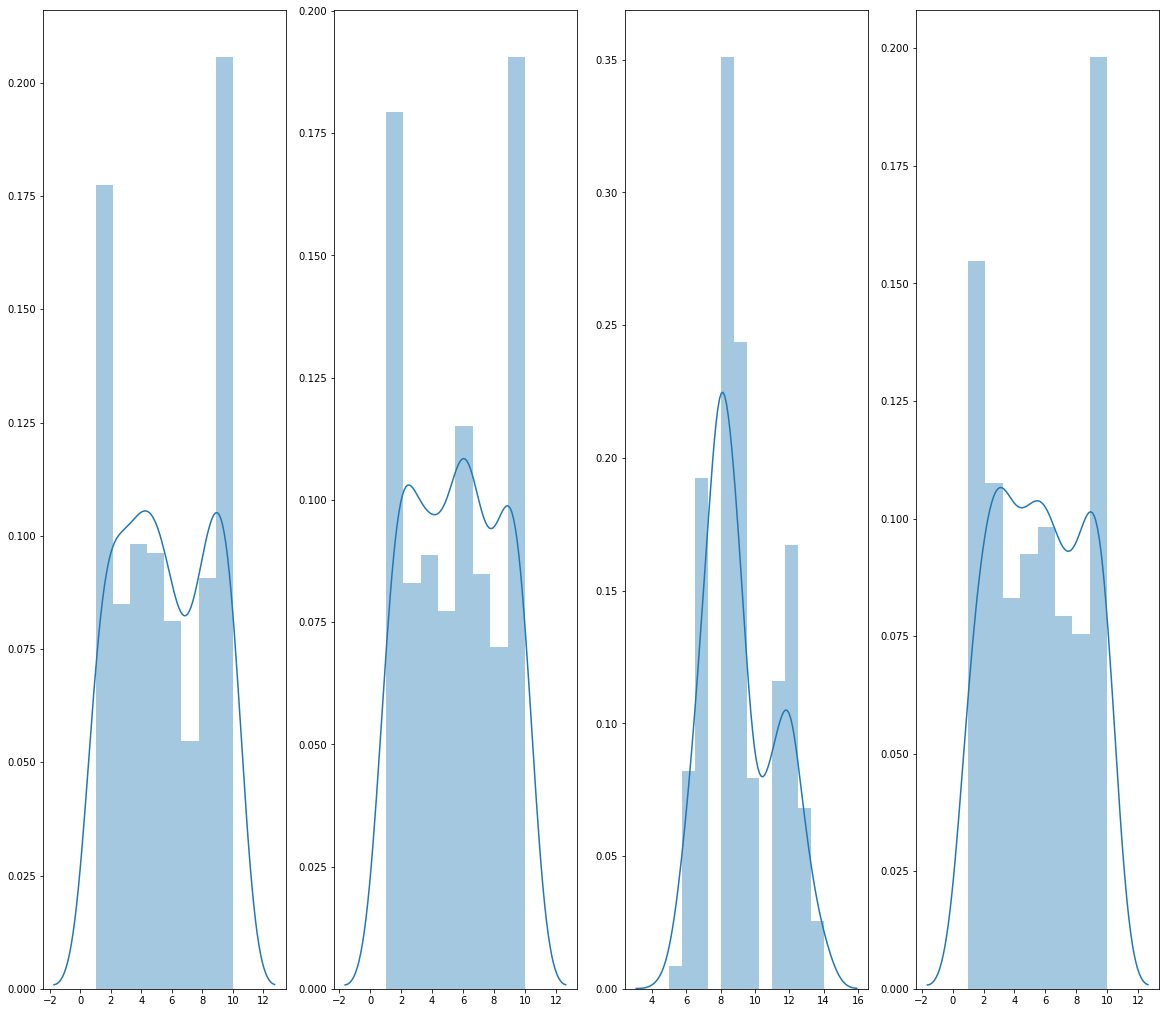

In [25]:
plt.figure(figsize=(20,18))
for i,col in enumerate(chem_list):
    plt.subplot(1,len(chem_list),i+1)
    sns.distplot(data.select(col).toPandas())

**Nhận xét:**
Vì các hợp chât đều có phân phối chuẩn nên ta chọn phương pháp Standard Scaling

In [42]:
for col in chem_list:
    mean = data.agg({col:'mean'}).collect()[0][0]
    std = data.agg({col:'stddev'}).collect()[0][0]
    data = data.withColumn(col + '_scaled', (data[col]-mean)/std)

### Ensemble Data

In [45]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [47]:
ensemble = VectorAssembler(inputCols=['A_scaled', 'B_scaled', 'C_scaled', 'D_scaled'],outputCol='features')

In [48]:
data = ensemble.transform(data)

In [50]:
final_data = data.select('features','Spoiled')

### Apply Decision Tree

In [51]:
from pyspark.ml.classification import DecisionTreeClassifier

In [52]:
tree_clf = DecisionTreeClassifier(labelCol='Spoiled')

In [53]:
tree_model = tree_clf.fit(final_data)

In [55]:
tree_model.featureImportances

SparseVector(4, {1: 0.002, 2: 0.9828, 3: 0.0152})

**Nhận xét:** Hóa chất C là tác nhân chính gây ra việc ngộ độc 